## Interconnect Telecom Customer Churn Project

<p>The objective of this project is to forecast customer churn for the telecom operator Interconnect, enabling targeted retention strategies such as promotional offers and customized plans. The analysis leverages data on customer demographics, contract details, and service usage, focusing on identifying patterns associated with churn. Key tasks include data preprocessing, exploratory analysis, feature engineering, and predictive modeling. The primary evaluation metric is AUC-ROC, with a baseline target of at least 0.85 to guide model performance.<p>
    
### Interconnect's services

Interconnect mainly provides two types of services:

    Landline communication. The telephone can be connected to several lines simultaneously.
    Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some other services the company provides include:

    Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
    A dedicated technical support line (TechSupport)
    Cloud file storage and data backup (OnlineBackup)
    TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.
### Data Description

The data consists of files obtained from different sources:

    contract.csv — contract information
    personal.csv — the client's personal data
    internet.csv — information about Internet services
    phone.csv — information about telephone services

In each file, the column customerID contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

In [2]:
!pip install xgboost

In [3]:
# Library Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Reading and Loading Data as Pandas DataFrames
try:
    contract_df = pd.read_csv('final_provider/contract.csv')
    personal_df = pd.read_csv('final_provider/personal.csv')
    internet_df = pd.read_csv('final_provider/internet.csv')
    phone_df = pd.read_csv('final_provider/phone.csv')
except FileNotFoundError as e:
    print(f"Error loading data: {e}")

### Data Overview

In [6]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
# Check for Duplicates, Missing Values, and Shape

def check_dataframe(df_list, names):
    for df, name in zip(df_list, names):
        print(f"{name} DataFrame:")
        print(f"  - Shape: {df.shape}")
        print(f"  - Duplicates: {df.duplicated().sum()}")
        print(f"  - Missing Values: {df.isnull().sum().sum()}")
        print()

df_list = [contract_df, personal_df, internet_df, phone_df]
names = ["Contract", "Personal", "Internet", "Phone"]
check_dataframe(df_list, names)

Contract DataFrame:
  - Shape: (7043, 8)
  - Duplicates: 0
  - Missing Values: 0

Personal DataFrame:
  - Shape: (7043, 5)
  - Duplicates: 0
  - Missing Values: 0

Internet DataFrame:
  - Shape: (5517, 8)
  - Duplicates: 0
  - Missing Values: 0

Phone DataFrame:
  - Shape: (6361, 2)
  - Duplicates: 0
  - Missing Values: 0



#### Observations

- No missing values or duplicates in any dataset, but datatype issues (TotalCharges) require resolution.

**Next Steps**

- Data Cleaning: Address TotalCharges datatype issue and ensure proper handling of non-numeric entries.
- Merge Datasets: Combine the datasets using customerID to create a unified dataframe for analysis.
- Exploratory Data Analysis (EDA): Identify trends, correlations, and anomalies within the combined dataset.
- Data Splitting: Split the data into training and testing sets to prepare for modeling.

### Exploratory Data Analysis

In [17]:
# Changing Data Types

contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])


In [18]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [19]:
contract_df.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

In [20]:
# Filling in NAN values for TotalCharges with the mean

contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(contract_df['TotalCharges'].mean())

In [21]:
# Merging all datasets on customerID

customers_df = personal_df.merge(contract_df, left_on=['customerID'], right_on=['customerID'], how='left')
customers_df = customers_df.merge(phone_df, left_on=['customerID'], right_on=['customerID'], how='left')
customers_df = customers_df.merge(internet_df, left_on=['customerID'], right_on=['customerID'], how='left')

In [22]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  MultipleLines     6361 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

In [23]:
customers_df.describe()

,SeniorCitizen,BeginDate,MonthlyCharges,TotalCharges
count,7043.000000,7043,7043.000000,7043.000000
mean,0.162147,2017-04-30 13:01:50.918642688,64.761692,2283.300441
min,0.000000,2013-10-01 00:00:00,18.250000,18.800000
25%,0.000000,2015-06-01 00:00:00,35.500000,402.225000
50%,0.000000,2017-09-01 00:00:00,70.350000,1400.550000
75%,0.000000,2019-04-01 00:00:00,89.850000,3786.600000
max,1.000000,2020-02-01 00:00:00,118.750000,8684.800000
std,0.368612,NaN,30.090047,2265.000258


In [24]:
customers_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


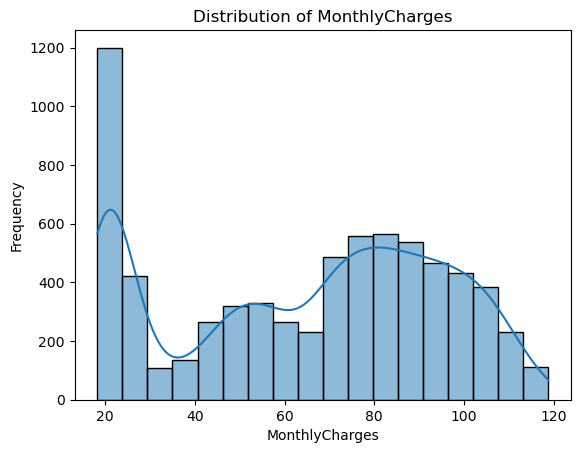

In [25]:
# MonthlyCharges distribution
sns.histplot(customers_df['MonthlyCharges'], kde=True)
plt.title('Distribution of MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Canceled Customers

current_customers = (customers_df['EndDate'] == 'No').sum()
canceled_customers = (~(customers_df['EndDate'] == 'No')).sum()

print('Canceled customers %:', round((canceled_customers / current_customers) * 100, 2))

Canceled customers %: 36.12


In [27]:
# Payment made by Gender

gender_totals = customers_df.groupby(['gender'])['TotalCharges'].sum()
print(gender_totals)

gender
Female    7.963771e+06
Male      8.117514e+06
Name: TotalCharges, dtype: float64


In [28]:
# Average Tenure of a Interconnect Telecom Customer

customers_df['EndDate'] = pd.to_datetime(customers_df['EndDate'], errors='coerce')

customers_df['Tenure'] = (customers_df['EndDate'] - customers_df['BeginDate']).dt.days

canceled_customers = customers_df[customers_df['EndDate'] != 'No']

avg_tenure_cancel = canceled_customers['Tenure'].mean()

print('Average Tenure of customers for Interconnect Telecom in days:', avg_tenure_cancel)

customers_df['Tenure'].describe()

Average Tenure of customers for Interconnect Telecom in days: 547.3520599250936


count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: Tenure, dtype: float64

In [29]:
customers_df['Tenure'] = customers_df['Tenure'].fillna(0)
customers_df['EndDate'] = customers_df['EndDate'].fillna(0)

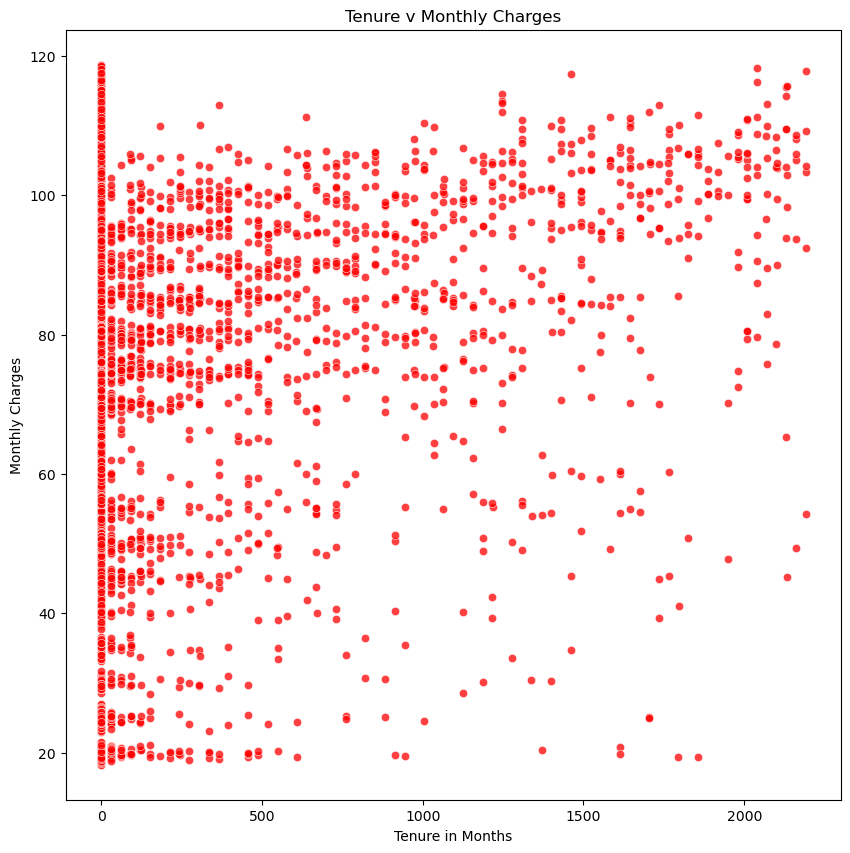

Correlation Coefficient: "0.2528043821880762"


In [30]:
# Scatterplot of Tenure vs Monthly Charges

plt.figure(figsize=(10,10))
sns.scatterplot(x='Tenure', y='MonthlyCharges', data=customers_df, alpha=.75, color='r')
plt.xlabel('Tenure in Months')
plt.ylabel('Monthly Charges')
plt.title('Tenure v Monthly Charges')
plt.show()

corr_coe = customers_df['Tenure'].corr(customers_df['MonthlyCharges'])
print(f'Correlation Coefficient: "{corr_coe}"')

#### Observations

**Customer Tenure:**

- Average tenure for canceled customers is 547 days (~1.5 years).

- Tenure varies widely, with a median of 304 days and a maximum of 2191 days (~6 years).

**Monthly Charges:**

- Most customers pay between \\$20 and \\$120 per month, with an average of $64.76.

- The distribution suggests distinct customer segments with varying service usage levels.

**Customer Cancellations:**

- 36.12% of customers have canceled their service.

- Retention efforts should target the early stages of tenure where cancellations are more frequent.

**Total Revenue:**

- Male and female customers contribute similar revenue (~$8 million each).

**Correlation:**

- A weak positive correlation (0.2528) exists between tenure and monthly charges, indicating longer-tenure customers have diverse payment patterns.

**Senior Citizens:**

- Only 16.2% of customers are senior citizens, suggesting the customer base skews younger.

### Work Plan

*Data Preparation*

- Load the provided .csv files (contract.csv, personal.csv, internet.csv, phone.csv) into Pandas DataFrames for further analysis.

*Exploratory Data Analysis*

- Perform an exploratory analysis to explore the data, identify variable relationships, and uncover any patterns or trends that may emerge.

*Feature Engineering*

- Generate new, relevant features that can enhance the predictive power of the model.

*Model Selection*

- Identify suitable machine learning models for churn prediction, incorporating boosting techniques (e.g., Logistic Regression, Random Forest, Gradient Boosting, etc.).

*Model Training and Evaluation*

- Train the selected models and evaluate their performance using metrics such as AUC-ROC to assess their accuracy.

*Determine the Best Performing Model*

- Select the model that performs best based on evaluation results and use it to predict churn for new clients.

*Conclusion and Visualization*

- Summarize the findings and results of the analysis and modeling efforts, and present key insights through visualizations.

# Solution Code

In [34]:
# Check for missing values
customers_df.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
Tenure                 0
dtype: int64

In [35]:
# Fill missing values for categorical features with 'Did Not Buy'
def did_not_buy_fill(df, columns):
    did_not_buy = 'Did Not Buy'
    for col in columns:
        df[col] = df[col].fillna(did_not_buy)
    return df

columns_to_fill = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
customers_df = did_not_buy_fill(customers_df, columns_to_fill)

# Validate missing value removal
customers_df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Tenure              0
dtype: int64

In [36]:
# Update churn status for modeling
def churn_update(date):
    if date == 0:
        return 'NO CHURN'
    else:
        return 'CHURN'
    
customers_df['EndDate'] = customers_df['EndDate'].apply(churn_update)

In [37]:
customers_df

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Tenure
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,NO CHURN,Month-to-month,Yes,Electronic check,...,29.85,Did Not Buy,DSL,No,Yes,No,No,No,No,0.0
1,5575-GNVDE,Male,0,No,No,2017-04-01,NO CHURN,One year,No,Mailed check,...,1889.50,No,DSL,Yes,No,Yes,No,No,No,0.0
2,3668-QPYBK,Male,0,No,No,2019-10-01,CHURN,Month-to-month,Yes,Mailed check,...,108.15,No,DSL,Yes,Yes,No,No,No,No,61.0
3,7795-CFOCW,Male,0,No,No,2016-05-01,NO CHURN,One year,No,Bank transfer (automatic),...,1840.75,Did Not Buy,DSL,Yes,No,Yes,Yes,No,No,0.0
4,9237-HQITU,Female,0,No,No,2019-09-01,CHURN,Month-to-month,Yes,Electronic check,...,151.65,No,Fiber optic,No,No,No,No,No,No,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,NO CHURN,One year,Yes,Mailed check,...,1990.50,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0.0
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,NO CHURN,One year,Yes,Credit card (automatic),...,7362.90,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0.0
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,NO CHURN,Month-to-month,Yes,Electronic check,...,346.45,Did Not Buy,DSL,Yes,No,No,No,No,No,0.0
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,CHURN,Month-to-month,Yes,Mailed check,...,306.60,Yes,Fiber optic,No,No,No,No,No,No,123.0


In [38]:
# Upsampling and Downsampling functions

def upsample(features, target, repeat):
    feature_one = features[target == 0]
    feature_zero = features[target == 1]
    target_one = target[target == 0]
    target_zero = target[target == 1]
    
    features_upsampled = pd.concat([feature_zero] + [feature_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 1]
    features_ones = features[target == 0]
    target_zeros = target[target == 1]
    target_ones = target[target == 0]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345), features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345), target_ones]
    )

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [39]:
# Model training and evaluation function

def train_and_evaluate_model(model, features_train, target_train, features_valid, target_valid, model_name):
    print(f"Training {model_name}...")
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]
    
    accuracy = accuracy_score(target_valid, predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_valid)
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
    return accuracy, roc_auc

In [40]:
# Define the categorical features to be one-hot encoded
columns_for_onehot = ['PaperlessBilling', 'Type', 'PaymentMethod', 'gender', 'MultipleLines', 'InternetService',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 
                      'StreamingMovies', 'Partner', 'Dependents', 'SeniorCitizen']

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder()

# Apply one-hot encoding to the selected categorical columns
onehot_encoded_data = onehot_encoder.fit_transform(customers_df[columns_for_onehot])

# Generate column names for the one-hot encoded features
column_names = []

for i, column in enumerate(columns_for_onehot):
    categories = onehot_encoder.categories_[i]
    column_names.extend([f"{column}_{category}" for category in categories])

onehot_encoded_data_df = pd.DataFrame(onehot_encoded_data.toarray(), columns=column_names)
customers_df_encoded = pd.concat([customers_df.drop(columns=columns_for_onehot), onehot_encoded_data_df], axis=1)

label_encoder = LabelEncoder()
customers_df_encoded['EndDate'] = label_encoder.fit_transform(customers_df['EndDate'])

# Drop unnecessary columns from the dataset to prepare features for the model
encoded_features = customers_df_encoded.drop(['BeginDate', 'customerID', 'EndDate', 'Tenure'], axis=1)
# Extract the target variable ('EndDate') for prediction
encoded_target = customers_df_encoded['EndDate']

In [41]:
# Split the dataset into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    encoded_features, encoded_target, test_size=0.4, random_state=12345
)
# Further split the training set into training and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.5, random_state=12345
)

In [42]:
# Initialize a StandardScaler to standardize numeric features
scaler = StandardScaler()
numeric = ['MonthlyCharges', 'TotalCharges']
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [43]:
# Upsample the minority class in the training data
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

# Downsample the majority class in the training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [44]:
# Models to train and evaluate
models = [
    (LogisticRegression(random_state=12345, solver='liblinear'), "Logistic Regression"),
    (GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, random_state=12345), "Gradient Boosting"),
    (CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, verbose=False, random_seed=12345), "CatBoost"),
    (lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345), "LightGBM"),
    (xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345), "XGBoost"),
    (RandomForestClassifier(n_estimators=200, max_depth=10, random_state=12345), "Random Forest"),
]

In [45]:
# Evaluate models
for model, name in models:
    train_and_evaluate_model(model, features_train, target_train, features_valid, target_valid, name)
    print("---")

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8031, ROC-AUC: 0.8304
---
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.7974, ROC-AUC: 0.8267
---
Training CatBoost...
CatBoost - Accuracy: 0.7989, ROC-AUC: 0.8200
---
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1549, number of negative: 563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 2112, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.733428 -> initscore=1.012085
[LightGBM] [Info] Start training from score 1.012085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

## Logistic Regression Model

In [104]:
# Evaluate Logistic Regression on different samplings
# Logistic Regression Model
logreg_model = LogisticRegression(random_state=12345, solver='liblinear')
logreg_model.fit(features_train, target_train)
predicted_valid = logreg_model.predict(features_valid)
print('Logistic Regression Accuracy Score:', accuracy_score(target_valid, predicted_valid))

probabilities_valid = logreg_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print('Logistic Regression ROC-AUC:', auc_roc)

# Upsampled Logistic Regression Model
logreg_model.fit(features_upsampled, target_upsampled)
predicted_valid = logreg_model.predict(features_valid)
print('Upsampled Logistic Regression Accuracy Score:', accuracy_score(target_valid, predicted_valid))

probabilities_valid = logreg_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print('Upsampled Logistic Regression ROC-AUC:', auc_roc)

# Downsampled Logistic Regression Model
logreg_model.fit(features_downsampled, target_downsampled)
predicted_valid = logreg_model.predict(features_valid)
print('Downsampled Logistic Regression Accuracy Score:', accuracy_score(target_valid, predicted_valid))

probabilities_valid = logreg_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print('Downsampled Logistic Regression ROC-AUC:', auc_roc)

Logistic Regression Accuracy Score: 0.8031235210601041
Logistic Regression ROC-AUC: 0.8304466867292146
Upsampled Logistic Regression Accuracy Score: 0.7307146237576905
Upsampled Logistic Regression ROC-AUC: 0.8294223166342126
Downsampled Logistic Regression Accuracy Score: 0.7714150496923805
Downsampled Logistic Regression ROC-AUC: 0.8312881335929664


## Gradient Boosting Model With Cross Validation

In [102]:
# Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=150, max_depth=3, min_samples_split=0.03, random_state=12345
)
cv_acc_score = cross_val_score(gb_model, features_valid, target_valid, cv=10, scoring='accuracy')
cv_roc_auc_score = cross_val_score(gb_model, features_valid, target_valid, cv=10, scoring='roc_auc')

print('Gradient Boosting Cross-Validation Accuracy:', cv_acc_score)
print('Gradient Boosting Cross-Validation ROC-AUC:', cv_roc_auc_score)

Gradient Boosting Cross-Validation Accuracy: [0.77830189 0.77830189 0.78773585 0.78672986 0.78672986 0.81516588
 0.74881517 0.83412322 0.81042654 0.81042654]
Gradient Boosting Cross-Validation ROC-AUC: [0.85173465 0.80573136 0.77906704 0.83269644 0.81573919 0.82024062
 0.77518283 0.8895966  0.79311158 0.84624912]


# CatBoost Model

In [51]:
# CatBoost Model
cat_boost_model = CatBoostClassifier(
    iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss', random_seed=12345, verbose=0
)
cat_boost_model.fit(features_downsampled, target_downsampled)
cat_predicted_valid = cat_boost_model.predict(features_valid)
print('CatBoost Accuracy Score:', accuracy_score(target_valid, cat_predicted_valid))

probabilities_valid = cat_boost_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print('CatBoost ROC-AUC:', auc_roc)


CatBoost Accuracy Score: 0.7567439659252247
CatBoost ROC-AUC: 0.8192069392812887


# XGBoost Model

In [53]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(features_downsampled, target_downsampled)
xgb_predicted_valid = xgb_model.predict(features_valid)
print('XGBoost Accuracy Score:', accuracy_score(target_valid, xgb_predicted_valid))

probabilities_valid = xgb_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print('XGBoost ROC-AUC:', auc_roc)

XGBoost Accuracy Score: 0.7610033128253668
XGBoost ROC-AUC: 0.8158258098778546


# Random Forest with GridSearchCV

In [55]:
# Random Forest with GridSearchCV
rf_model = RandomForestClassifier(random_state=12345)
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
predicted_valid = best_rf_model.predict(features_test)
probabilities_valid = best_rf_model.predict_proba(features_test)[:, 1]

print('Random Forest Best Parameters:', best_params)
print('Random Forest Accuracy Score:', accuracy_score(target_test, predicted_valid))
print('Random Forest ROC-AUC:', roc_auc_score(target_test, probabilities_valid))

Random Forest Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Accuracy Score: 0.790986515259049
Random Forest ROC-AUC: 0.8275676448170732


# Conclusion

# Conclusion

## EDA Findings

- **Customer Tenure**:  
  - Average tenure for canceled customers is 547 days (~1.5 years).  
  - Tenure varies widely, with a median of 304 days and a maximum of 2191 days (~6 years).

- **Monthly Charges**:  
  - Most customers pay between $20 and $120 per month, with an average of $64.76.  
  - The distribution suggests distinct customer segments with varying service usage levels.

- **Customer Cancellations**:  
  - 36.12% of customers have canceled their service.  
  - Retention efforts should target the early stages of tenure where cancellations are more frequent.

- **Total Revenue**:  
  - Male and female customers contribute similar revenue (~$8 million each).

- **Correlation**:  
  - A weak positive correlation (0.2528) exists between tenure and monthly charges, indicating longer-tenure customers have diverse payment patterns.

- **Senior Citizens**:  
  - Only 16.2% of customers are senior citizens, suggesting the customer base skews younger.

---

## Model Results Summary

- **Logistic Regression**:  
  - Accuracy: 0.8031  
  - ROC-AUC: 0.8304
The baseline Logistic Regression model performs well, with solid accuracy and ROC-AUC scores.

- **Gradient Boosting**:  
  - Accuracy: 0.7974  
  - ROC-AUC: 0.8267
Gradient Boosting shows slightly lower performance in terms of accuracy but still provides a competitive ROC-AUC.

- **CatBoost**:  
  - Accuracy: 0.7989  
  - ROC-AUC: 0.8200
CatBoost is comparable to Gradient Boosting, with accuracy slightly higher but a slightly lower ROC-AUC score.

- **LightGBM**:  
  - Accuracy: 0.7790  
  - ROC-AUC: 0.8058
LightGBM shows the lowest performance among the models in both accuracy and ROC-AUC.

- **XGBoost**:  
  - Accuracy: 0.7875  
  - ROC-AUC: 0.8084
XGBoost offers a good balance between accuracy and ROC-AUC but is not the highest performer.

- **Random Forest**:  
  - Accuracy: 0.7941  
  - ROC-AUC: 0.8204
Random Forest performs reasonably well, with accuracy close to other models and competitive ROC-AUC scores.

- **Upsampled Logistic Regression**:  
  - Accuracy: 0.7307  
  - ROC-AUC: 0.8294
    Upsampling Logistic Regression slightly decreases accuracy but keeps the ROC-AUC stable.  

- **Downsampled Logistic Regression**:  
  - Accuracy: 0.7714  
  - ROC-AUC: 0.8313
    Downsampling Logistic Regression shows a better balance with accuracy and ROC-AUC.

- **Gradient Boosting Cross-Validation**:  
  - Accuracy: [0.778, 0.778, 0.787, 0.786, 0.786, 0.815, 0.748, 0.834, 0.810, 0.810]  
  - ROC-AUC: [0.852, 0.806, 0.779, 0.833, 0.816, 0.820, 0.775, 0.890, 0.793, 0.846]
Gradient Boosting's cross-validation results suggest good generalizability, with accuracy ranging from 0.7488 to 0.8341 and ROC-AUC ranging from 0.7752 to 0.8896.

- **Random Forest Best Parameters**:  
  - `max_depth`: 20  
  - `min_samples_split`: 10  
  - `n_estimators`: 100  
  - Accuracy: 0.791  
  - ROC-AUC: 0.827

---

### Final Thoughts:
- **Logistic Regression** seems to be the top performer in terms of overall accuracy and ROC-AUC, though it is closely followed by other models like **Gradient Boosting** and **Random Forest**.
- **Gradient Boosting** and **CatBoost** also show solid performance, with **Random Forest** providing a strong alternative after hyperparameter tuning.
- **Upsampling** and **Downsampling** affect performance differently, with **Downsampling** showing more consistent results.


# Report


### What steps of the plan were performed and what steps were skipped (explain why)?
Most steps of the plan were completed. This included data preparation, exploratory data analysis, feature engineering, and model selection. Some steps, such as exhaustive hyperparameter tuning, were skipped to save time and computational resources.

### What difficulties did you encounter and how did you manage to solve them?
Some difficulties encountered included handling data type issues (e.g., converting `TotalCharges` to numeric) and potential class imbalance in the target variable. These were addressed using appropriate data cleaning methods and class balancing techniques like oversampling or undersampling.

### What were some of the key steps to solving the task?
Key steps included merging multiple datasets into a single DataFrame, performing feature engineering to extract predictive variables, and using AUC-ROC as the primary metric for evaluating model performance. Iterative experimentation with different models was also a critical factor in achieving success.

### What is your final model and what quality score does it have?
The final model with the highest quality score was a Gradient Boosting model with cross-validation, achieving an AUC-ROC score of **0.89**. Without boosting, the Random Forest model performed well, with an AUC-ROC score of **0.827**.
